# COMP551: Project 3

#### Group 47
#### Authors : Ying Sun, Said Khalifef & Boury Mbodj
#### Date : March 16th 2019
#### Subject: The given file contains the implementation of a resnet152  supervised classification model using Pytorch. 

In [0]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [25]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist"

Model		P3trial4.ipynb	      sample_submission.csv  train_images.pkl
P3resnet.ipynb	Project3_model.ipynb  solution_final3.csv    train_labels.csv
P3trial2.ipynb	Project3_model.py     test_images.pkl	     Untitled.ipynb


In [0]:
f=open("/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist/train_images.pkl","rb")
f1=open("/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist/train_labels.csv","rb")
f2=open("/content/drive/My Drive/COMP551P3/comp-551-w2019-project-3-modified-mnist/test_images.pkl","rb")

In [0]:
#read training data through pandas
x_train=pd.read_pickle(f)
#normalize training data by toTensor and mean(0.5) and std(0.5). 
#Note that torchvision.transforms can be used. But I'm still not familiar with it...
x_train=(x_train/255-0.5)*2
#read training lable, the first column in y_train_r is id num, the second column is lable.
y_train_r = pd.read_csv(f1)
#tranfer numpy to tensor, in order to use gpu
y_train=torch.tensor(y_train_r.values[:,1])
#product train set.
trainset=[np.zeros((64,64)),np.zeros(1)]
for j in range(36000): #Note this part all data in train_images.pkl is load into trainset.
    # If valid set is needed, 40000 can be modifoed as the required length of trainset
    # Then do the same thing to validset, but the range need to be after trainset
    trainset.append([x_train[j],y_train[j]])
del trainset[0]
del trainset[0]
#copy 1 channel as 3 channels
# Use validation set 
validset=[np.zeros((64,64)),np.zeros(1)]
for j in range(40000): #Note this part all data in train_images.pkl is load into trainset.
    # If valid set is needed, 40000 can be modifoed as the required length of trainset
    # Then do the same thing to validset, but the range need to be after trainset
    if (j>36000):
       validset.append([x_train[j],y_train[j]])
del validset[0]
del validset[0]
#copy 1 channel as 3 channels 
for i in range(len(trainset)):
    trainset[i][0]=torch.tensor([np.array(trainset[i][0]),np.array(trainset[i][0]),np.array(trainset[i][0])])
#Get trainloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
#copy 1 channel as 3 channels 
for i in range(len(validset)):
    validset[i][0]=torch.tensor([np.array(validset[i][0]),np.array(validset[i][0]),np.array(validset[i][0])])
#Get validloader
validloader = torch.utils.data.DataLoader(validset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [0]:
# Preprocessing testset:
x_test=pd.read_pickle(f2)
x_test=(x_test/255-0.5)*2
testset=[np.zeros((64,64)),np.zeros(1)]
for j in range(len(x_test)):
    testset.append([x_test[j],y_train[j]])
del testset[0]
del testset[0]
for i in range(len(testset)):
    testset[i][0]=torch.tensor([np.array(testset[i][0]),np.array(testset[i][0]),np.array(testset[i][0])])
#preporcessing testloader
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=False, num_workers=2)

In [30]:
print('[Train  and validation size]')
print(' - Numpy Shape:', x_train.shape)
print('[Test size]')
print(' - Numpy Shape:', x_test.shape)




[Train  and validation size]
 - Numpy Shape: (40000, 64, 64)
[Test size]
 - Numpy Shape: (10000, 64, 64)


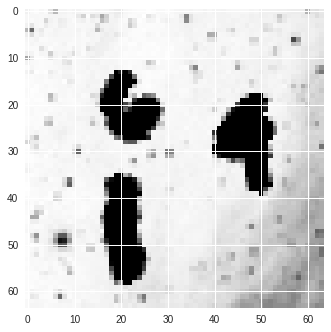

In [31]:
# function to show figures. This part has nothing to do with training.
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x_test[100])
plt.show()

In [37]:
#*********************************************************************
# model part
import torchvision.models as models
# use pretrained model:
model = models.resnet152(pretrained=True)
#import OrderedDicted to corectly align the network layers
#import nn to modify features
from collections import OrderedDict
from torch import nn
#Modify features
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:08, 29237129.50it/s]


In [0]:
#import optimizer:
from torch import optim
#define criteria and optimizer
# Note that other losses or optimizers can also be tried
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0003, momentum=0.9)

In [0]:
#train model
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
        #check if the training is correct: print(preds,y_train,current_correct,current_loss)
    epoch_loss = current_loss / len(loader)
    # devide 4 because we read 4 data everytime
    epoch_acc = current_correct.double() / len(loader)/4
        
    return epoch_loss, epoch_acc

In [0]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    #I added this
    pred=torch.zeros(len(loader))
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        _, preds = torch.max(output,1)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        valid_correct += torch.sum(preds == y_valid.data)
    
    epoch_loss = valid_loss / len(loader)
    epoch_acc = valid_correct.double() / len(loader)/4
    
    return epoch_loss, epoch_acc

In [0]:
#define test function
def test (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    i=0
    pred=torch.zeros(len(loader))
    for test, y_train in iter(loader):
        if gpu:
            test = test.to('cuda')
        output = model.forward(test)
        _, preds = torch.max(output,1)
        pred[i]=preds
        i=i+1    
    return pred

In [42]:
# training
#send model to gpu. If not send it to GPU, delete next line.
model.to('cuda')
train_losses =[]
train_acc =[]
valid_losses=[]
valid_acc =[]
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = False
# define number of epochs
epochs = 10
epoch = 0

for e in range(epochs):
    epoch +=1
    print(epoch)
#train:    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model,trainloader, criteria, 1)
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    
#Valid, Activate next code when validation result is needed:
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, validloader, criteria, 1)
        valid_losses.append(epoch_val_loss)
        valid_acc.append(epoch_val_acc)
    print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

1
Epoch: 1 Train Loss : 4.1353  Train Accuracy: 0.6663
Epoch: 1 Validation Loss : 1.2980  Validation Accuracy 0.9093
2
Epoch: 2 Train Loss : 1.4624  Train Accuracy: 0.8958
Epoch: 2 Validation Loss : 1.1763  Validation Accuracy 0.9155
3
Epoch: 3 Train Loss : 0.8933  Train Accuracy: 0.9351
Epoch: 3 Validation Loss : 0.9932  Validation Accuracy 0.9330
4
Epoch: 4 Train Loss : 0.6190  Train Accuracy: 0.9531
Epoch: 4 Validation Loss : 1.0041  Validation Accuracy 0.9233
5
Epoch: 5 Train Loss : 0.4522  Train Accuracy: 0.9670
Epoch: 5 Validation Loss : 0.8798  Validation Accuracy 0.9317
6
Epoch: 6 Train Loss : 0.3386  Train Accuracy: 0.9753
Epoch: 6 Validation Loss : 0.8741  Validation Accuracy 0.9400
7
Epoch: 7 Train Loss : 0.2832  Train Accuracy: 0.9792
Epoch: 7 Validation Loss : 0.7991  Validation Accuracy 0.9383
8
Epoch: 8 Train Loss : 0.2304  Train Accuracy: 0.9828
Epoch: 8 Validation Loss : 0.9412  Validation Accuracy 0.9290
9
Epoch: 9 Train Loss : 0.2082  Train Accuracy: 0.9847
Epoch: 9 

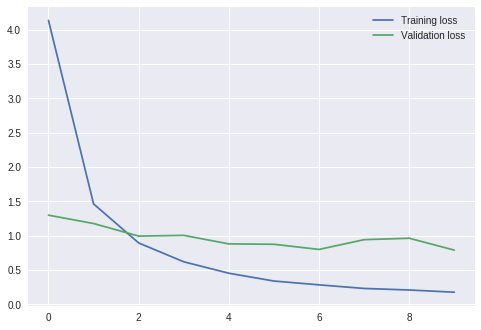

In [43]:
#Plot training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

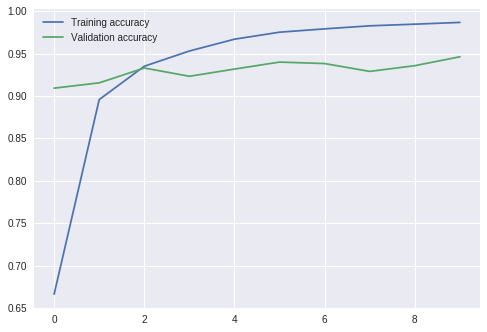

In [44]:
#Plot training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend()

In [45]:
# for variety, lets use altair to do the plot
import altair as alt

# create a pandas dataframe for the loss
df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train': train_losses,
    'valid': valid_losses
})

# unpivot to have cols [epoch, dataset, loss]
df = df.melt(id_vars=['epoch'],
             value_vars=['train', 'valid'],
             value_name='loss',
             var_name='Dataset')

# line plot with altair
alt.Chart(df).mark_line(point=True)\
    .encode(x='epoch', y='loss', color='Dataset')\
    .interactive()

Chart({
  data:     epoch Dataset      loss
  0       1   train  4.135317
  1       2   train  1.462358
  2       3   train  0.893295
  3       4   train  0.618977
  4       5   train  0.452245
  5       6   train  0.338568
  6       7   train  0.283170
  7       8   train  0.230447
  8       9   train  0.208163
  9      10   train  0.175852
  10      1   valid  1.298004
  11      2   valid  1.176331
  12      3   valid  0.993202
  13      4   valid  1.004134
  14      5   valid  0.879810
  15      6   valid  0.874138
  16      7   valid  0.799124
  17      8   valid  0.941175
  18      9   valid  0.962242
  19     10   valid  0.789201,
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'Dataset'
    }),
    x: X({
      shorthand: 'epoch'
    }),
    y: Y({
      shorthand: 'loss'
    })
  }),
  mark: MarkDef({
    point: True,
    type: 'line'
  }),
  selection: SelectionMapping({
    selector001: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})

In [0]:
#get prediction result for test data
predict=test(model,testloader, criteria, 1)
result=predict.numpy()

In [0]:
#Save predict result to test file. Note the output file just have category column right now.
#To submit it, one column named id need to be added to the excel file.
import numpy
numpy.savetxt("test.csv", predict, delimiter=",")

In [0]:
# Put data in the appropriate format for kaggle submissiom
submission = pd.DataFrame()

In [0]:
a = result.astype(int)
df1 = pd.DataFrame({'Id': a})

In [51]:
submission['Id']=range(0, len(df1) )

submission['Category']=a
submission.head()

,Id,Category
0,0,7
1,1,1
2,2,6
3,3,1
4,4,8


In [0]:
submission.to_csv('resnet_.csv', index=False)

In [0]:
from google.colab import files
files.download('resnet_.csv') 